In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import os
import random

from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Lambda, ELU
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


In [2]:
X_train = np.load('trial_X.npy')
y_train = np.load('trial_y.npy')

In [3]:


data = pd.read_csv('./data/driving_log.csv')


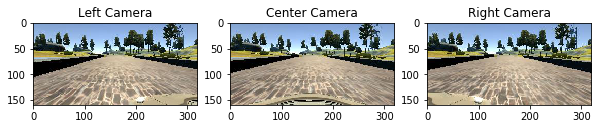

In [5]:
def convert_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def read_image(path):
    return cv2.imread('data/IMG/' + path)

img_left = read_image(data['left'][0].strip())
img_center = read_image(data['center'][0].strip())
img_right = read_image(data['right'][0].strip())

plt.figure(figsize=(10,4))

plt.subplot(131)
plt.imshow(convert_rgb(img_left))
plt.title('Left Camera')

plt.subplot(132)
plt.imshow(convert_rgb(img_center))
plt.title('Center Camera')

plt.subplot(133)
plt.imshow(convert_rgb(img_right))
plt.title('Right Camera')

plt.show()


In [6]:
data.head()
# print(len(data))

,center,left,right,steering,throttle,brake,speed
0,center_2016_12_01_13_30_48_287.jpg,left_2016_12_01_13_30_48_287.jpg,right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,center_2016_12_01_13_30_48_404.jpg,left_2016_12_01_13_30_48_404.jpg,right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,center_2016_12_01_13_31_12_937.jpg,left_2016_12_01_13_31_12_937.jpg,right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,center_2016_12_01_13_31_13_037.jpg,left_2016_12_01_13_31_13_037.jpg,right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,center_2016_12_01_13_31_13_177.jpg,left_2016_12_01_13_31_13_177.jpg,right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


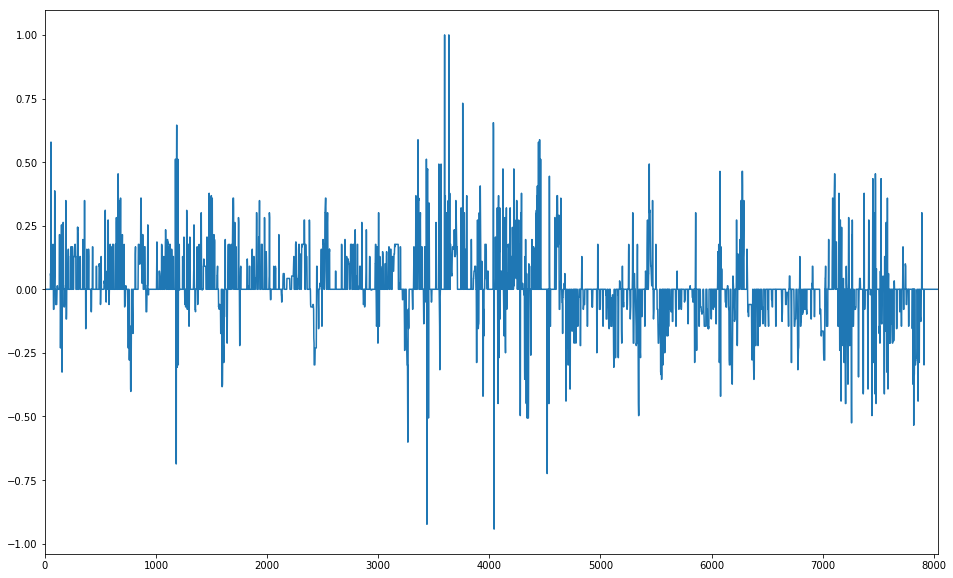

In [7]:
plt.figure(figsize=(16,10))
data['steering'].plot()
plt.show()

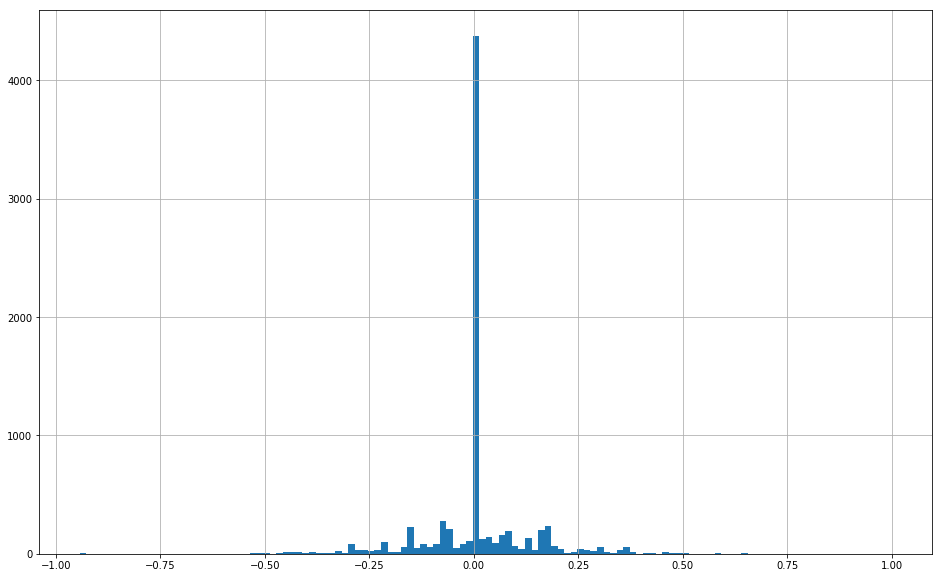

In [8]:
plt.figure(figsize=(16,10))
data['steering'].hist(bins = len(np.unique(data['steering'])))
plt.show()

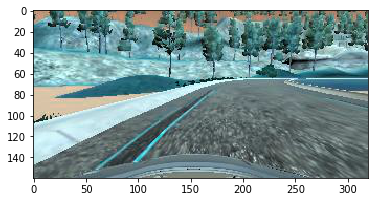

1.0
-1.0


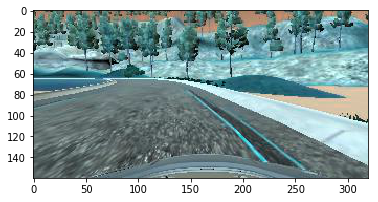

In [9]:
def flip_img(img):
    return np.fliplr(img)

def flip_angle(angle):
    return -angle

img = X_train[3598]
raw_img = img
img_flipped = flip_img(img)
ang = data['steering'][3598]
ang_flipped = flip_angle(ang)
plt.imshow(img)
plt.show()
print(ang)
plt.imshow(img_flipped)
plt.show
print(ang_flipped)

In [10]:
print (next((x, i) for x, i in enumerate(data['steering']) if i >= 1))

(3598, 1.0)


In [11]:
print ([(x, i) for x, i in enumerate(data['steering']) if i >= 0.8][0])

(3598, 1.0)


In [12]:
def crop_img(img):
    return img[50:140, : ]

def resize_img(img):
    return cv2.resize(img, (200, 66))

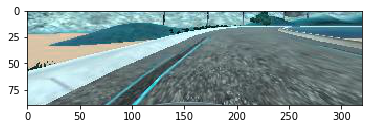

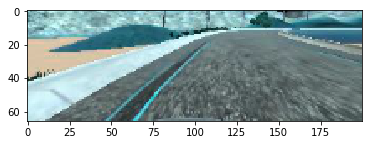

In [13]:
plt.imshow(crop_img(img))
plt.show()
plt.imshow(resize_img(crop_img(img)))
plt.show()

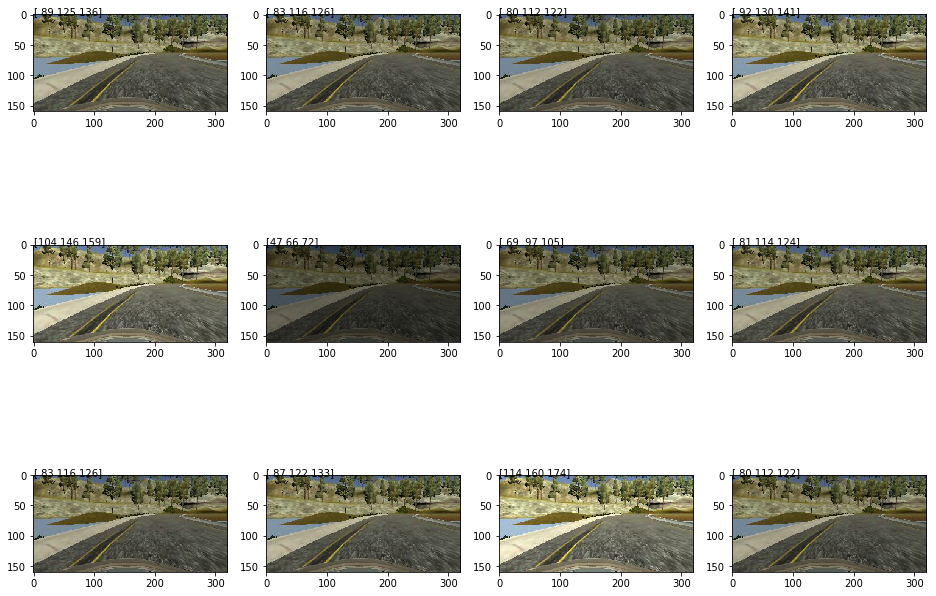

In [14]:
def random_contrast(img):
    img_temp = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_temp[:,:,2] = img_temp[:,:,2] * np.random.uniform(.4, 1.)
    img_temp = cv2.cvtColor(img_temp, cv2.COLOR_HSV2BGR)
    return img_temp

plt.figure(figsize=(16,12))
for i in range(12):
    plt.subplot(3, 4, i+1)
    temp = convert_rgb(random_contrast(raw_img))
    plt.imshow(temp)
    plt.text(0,0, temp[0][0])

plt.show()

In [15]:
def jitter_transition(img, angle):
    transRange = 50
    numPix = 10
    valPix = 0.1
    transX = transRange * np.random.uniform() - transRange / 2
    angle = angle + transX / transRange * 2 * valPix
    transY = numPix * np.random.uniform() - numPix / 2
    transMat = np.float32([[1, 0, transX], [0, 1, transY]])
    img = cv2.warpAffine(img, transMat, (200, 66))
    
    return img, angle



def transition_image(img, angle):
    trans_val_x = .50
    trans_val_y = .015
    trans_x = trans_val_x * np.random.uniform() - trans_val_x / 2
    angle = angle + trans_x / trans_val_x * 2 * 0.2
    trans_y = trans_val_y * np.random.uniform() - trans_val_y / 2
    trans_mat = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    img = cv2.warpAffine(img, trans_mat,(200,66))
    
    return img, angle
def select_camera(path):
    camera_selection = [0, 1, 2]
#     camera_selection = [1]
    camera_choice = random.choice(camera_selection)
    if camera_choice == 0:
        camera_file = path['left']
        ang = path['steering'][0] + 0.25
    elif camera_choice == 1:
        camera_file = path['center']
        ang = path['steering'][0]
    elif camera_choice == 2:
        camera_file = path['right']
        ang = path['steering'][0] - 0.25
        
    return camera_file, ang
    
def preprocess_train(img, ang):
    img = crop_img(img)
    img = resize_img(img)
    img = random_contrast(img)
#     img, ang = transition_image(img, ang)
    img, ang = jitter_transition(img, ang)
    flip_choice = random.choice([0, 1])
    if flip_choice == 1:
        img = flip_img(img)
        ang = flip_angle(ang)
    else:
        img = img
        ang = ang
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, ang

# def preprocess_valid(img, ang):
#     img = crop_img(img)
#     img = resize_img(img)
#     img = random_contrast(img)
#     flip_choice = random.choice([0, 1])
#     if flip_choice == 1:
#         img = flip_img(img)
#         ang = flip_angle(ang)
#     return img, ang
processed_camera = select_camera(data.iloc[[3598]].reset_index())
print (processed_camera[0][0].strip())
comeon = cv2.imread('data/' + processed_camera[0][0].strip())
# print (comeon)
comeon = np.array(comeon)
# print (comeon)
print (processed_camera[1])
plt.imshow(preprocess_train(comeon, processed_camera[1])[0])
plt.show()
processed_img = preprocess_train(raw_img, ang)


print(raw_img.shape)
plt.imshow(raw_img)
plt.show()
plt.imshow(processed_img[0])
print(processed_img[1])
plt.text(0,-2,processed_img[1])
print (processed_img[0].shape)

left_2016_12_01_13_38_42_894.jpg
1.25


IndexError: too many indices for array

In [37]:
def train_pipe(path, batch_size = 250):
    csv_data = pd.read_csv(path + '/driving_log.csv')
    
#     batch_images = np.empty((batch_size, 66, 200, 3))
#     batch_angles = np.empty(batch_size)
    while True:
        batch_images = []
        batch_angles = []
        batch_full = False
        batch_count = 0
        actual_count = 0
#         for i in range(batch_size):
        while batch_full == False:
            
            line_loc = np.random.randint(0, len(csv_data))# - i)
            line_data = csv_data.iloc[[line_loc]].reset_index()
#             if batch_count < 3:
#                 print (batch_count)
#                 print (line_data)
#                 print (line_data['center'])
            image_file, angle = select_camera(line_data)
            image_file = image_file[0]
#             angle = angle[0]
#             print (image_file)
#             if len(image_file) > 50:
#                 image_file = image_file.lstrip(r"C:\Users\cyran\Documents\projects\data_alternative\\")
#                 image_file = image_file.lstrip(r"C:\Users\cyran\Documents\projects\data_training\\")
#                 image_file = image_file[2:]
#             print (image_file)
            final_path = path + '/IMG/' + image_file.strip()

            image = cv2.imread(final_path)


            image, angle = preprocess_train(image, angle)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#             if abs(angle) < 0.15:
#                 if np.random.uniform() > 0.1:
#                     batch_images[batch_count] = image
#                     batch_angles[batch_count] = angle
#                     batch_count += 1
#             else:
#                 batch_images[batch_count] = image
#                 batch_angles[batch_count] = angle
#                 batch_count += 1
            
#             batch_images[batch_count] = image
#             batch_angles[batch_count] = angle
            if abs(angle) < 0.15:
                if np.random.uniform() > 0.3:
                    batch_images.append(image)
                    batch_angles.append(angle)
                    batch_count += 1
            else:
                batch_images.append(image)
                batch_angles.append(angle)
                batch_count += 1
#             batch_images.append(image)
#             batch_angles.append(angle)
#             batch_count += 1
            
            if batch_count == batch_size:
                batch_full = True
            actual_count += 1
#             csv_data.drop(csv_data.index[line_loc])
            

        yield np.array(batch_images), np.array(batch_angles)
            
generate_batch = train_pipe('data_training')    

def valid_pipe(path):
    csv_data = pd.read_csv(path + '/driving_log.csv')
    
    while True:
        for i in range(len(csv_data)):
            line_data = csv_data.iloc[[i]].reset_index()
            image_path = line_data['center'][0].strip()
            image = cv2.imread(path + '/IMG/' + image_path)
            angle = line_data['steering'][0]
            
            image, angle = preprocess_train(image, angle)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = image.reshape(1, 66, 200, 3)
            angle = np.array([[angle]])
            yield image, angle
            
generate_valid = valid_pipe('data_training')

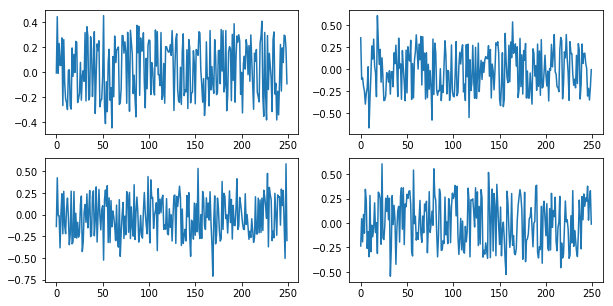

In [38]:
plt.figure(figsize=(10,5))
for i in range(4):
    x, y = next(generate_batch)
    plt.subplot(2, 2, i+1)
    plt.plot(y)
plt.show()



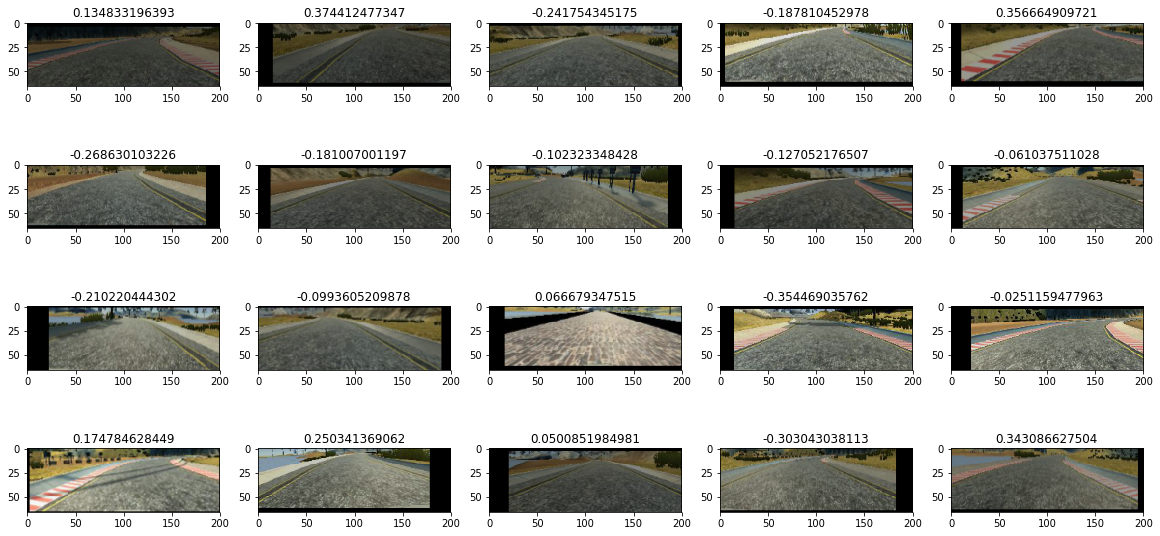

In [39]:
vis, dummy = next(generate_batch)
plt.figure(figsize=(20,10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(vis[i])
    plt.title(dummy[i])

In [40]:
def model_2():
    model = Sequential()
#     model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (64, 64, 3)))
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (66, 200, 3)))
    model.add(Flatten())
    model.add(Dense(1))

    model.compile(loss = 'mse', optimizer = 'adam')
#     model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 7)
    model.fit_generator(generate_batch, samples_per_epoch = 20000, nb_epoch = 3, validation_data = generate_valid, nb_val_samples = len(data))
    model.save('model_2.h5')

In [41]:
# model_2()

In [50]:
def model_nvidia_2():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape = (66,200,3)))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode = "valid", init = 'he_normal'))
    model.add(ELU())
    model.add(Dropout(0.3))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode = "valid", init = 'he_normal'))
    model.add(ELU())
    model.add(Dropout(0.3))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode = "valid", init = 'he_normal'))
    model.add(ELU())
    model.add(Dropout(0.3))
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode = "valid", init = 'he_normal'))
    model.add(ELU())
    model.add(Dropout(0.3))
#     model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode = "valid", init = 'he_normal'))
    model.add(ELU())
    model.add(Dropout(0.3))
#     model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(1164, init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.3))
    model.add(Dense(100, init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.3))
    model.add(Dense(50, init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.3))
    model.add(Dense(10, init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.3))
    model.add(Dense(1, init='he_normal'))
    
    model.compile(loss = 'mse', optimizer = 'adam')
#     model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 7)
    model.fit_generator(generate_batch, samples_per_epoch = 20000, nb_epoch = 21, validation_data = generate_valid, nb_val_samples = len(data))
    model.save('model_nvidia_7.h5')

In [51]:
model_nvidia_2()

Epoch 1/21
20000/20000 [==============================] - 77s - loss: 4.6105 - val_loss: 0.1338
Epoch 2/21
20000/20000 [==============================] - 69s - loss: 1.5284 - val_loss: 0.0658
Epoch 3/21
20000/20000 [==============================] - 70s - loss: 1.2878 - val_loss: 0.0627
Epoch 4/21
20000/20000 [==============================] - 70s - loss: 1.1513 - val_loss: 0.0401
Epoch 5/21
20000/20000 [==============================] - 70s - loss: 1.0217 - val_loss: 0.0405
Epoch 6/21
20000/20000 [==============================] - 70s - loss: 0.8908 - val_loss: 0.0331
Epoch 7/21
20000/20000 [==============================] - 71s - loss: 0.8024 - val_loss: 0.0435
Epoch 8/21
20000/20000 [==============================] - 71s - loss: 0.7088 - val_loss: 0.0365
Epoch 9/21
20000/20000 [==============================] - 70s - loss: 0.6006 - val_loss: 0.0257
Epoch 10/21
20000/20000 [==============================] - 71s - loss: 0.5433 - val_loss: 0.0282
Epoch 11/21
20000/20000 [==============